In [1]:
import keras
import numpy as np
from keras import activations

Using TensorFlow backend.


In [2]:
from keras import layers


def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)

    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = layers.BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = layers.Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    y = layers.add([shortcut, y])

    return y


In [3]:
from keras.models import Input, Model
from keras.layers import Conv2D
from keras.layers import Deconv2D

In [4]:
import tensorflow as tf
from keras.engine.topology import Layer
from keras.engine import InputSpec

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def get_output_shape_for(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

class Denormalize(Layer):
    '''
    Custom layer to denormalize the final Convolution layer activations (tanh)
    Since tanh scales the output to the range (-1, 1), we add 1 to bring it to the
    range (0, 2). We then multiply it by 127.5 to scale the values to the range (0, 255)
    '''

    def __init__(self, **kwargs):
        super(Denormalize, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        '''
        Scales the tanh output activations from previous layer (-1, 1) to the
        range (0, 255)
        '''

        return (x + 1) * 127.5

    def compute_output_shape(self,input_shape):
        return input_shape

    
    


In [5]:
"""
In this cell I define, functionally, the "image transformation" network from jc johnson's and li fei fei paper.
"""

inputs = Input(shape=[256, 256, 3])
o = ReflectionPadding2D(padding=(40,40))(inputs) #TODO: Check if the reflection padding is done as the paper
o = Conv2D(32, (9, 9), strides=(1,1), padding='same', activation='relu')(inputs)
o = Conv2D(64, (3, 3), strides=(2,2), padding='same', activation='relu')(o)
o = Conv2D(128, (3, 3), strides=(2,2), padding='same', activation='relu')(o)
o = residual_block(o, 128)
o = residual_block(o, 128)
o = residual_block(o, 128)
o = residual_block(o, 128) #TODO: check if the residual blocks are the same as the paper
o = residual_block(o, 128)
o = Deconv2D(64, (3, 3), strides=2, padding='same', activation='relu')(o)
o = Deconv2D(32, (3, 3), strides=2, padding='same', activation='relu')(o) #TODO: check if the output of this layer is the same as the fractional stride conv
o = Conv2D(3, (9, 9), strides=1, activation='tanh', padding='same')(o)
o = Denormalize()(o)

model_style_transfer = Model(inputs=inputs, outputs=o)


In [6]:
from keras.applications import VGG16

In [7]:
model_style_transfer.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 7808        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 128)  73856       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [8]:
vgg = VGG16(include_top=False)

In [9]:
vgg.summary() # let's see where to get our outputs for style

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [10]:
relu1_2 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=2).output])
relu2_2 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=5).output])
relu3_3 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=9).output])
relu4_3 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=13).output])

In [11]:
import cv2

In [78]:
im = cv2.imread("fortnite/34.png", cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)


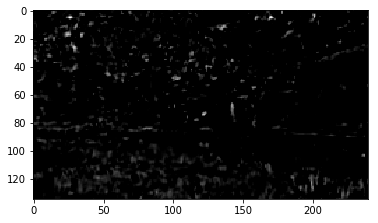

In [79]:
provaoutput = relu4_3.predict(np.array([im]))[0,:,:,43]

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(provaoutput, cmap='gray')
plt.show()

In [14]:
import tensorflow as tf
import keras.backend as K

def custom_objective(y_true, y_pred):
    '''Just another crossentropy'''
    y_true = tf.Variable(trainable=False, initial_value=tf.float32(0.0))
    distance = y_pred - y_true
    return distance

def gram_matrix_pre(x):
    if K.image_dim_ordering() == 'th':
        features = x.flatten()
    else:
        features = np.transpose(x, (2, 0, 1)).flatten()

    shape = np.shape(x)
    
    C, W, H = (shape[0],shape[1], shape[2])
    
    cf = np.reshape(features ,(C,-1))
    gram = np.dot(cf, np.transpose(cf)) /  np.float32(C*W*H)

    return gram

def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_dim_ordering() == 'th':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))

    shape = K.shape(x)
    
    C, W, H = (shape[0],shape[1], shape[2])
    
    cf = K.reshape(features ,(C,-1))
    gram = K.dot(cf, K.transpose(cf)) /  K.cast(C*W*H,dtype='float32')

    return gram




In [15]:
im = cv2.resize(im, (256, 256))
style_gram_1 = gram_matrix_pre(relu1_2.predict(np.array([im]))[0])
style_gram_2 = gram_matrix_pre(relu2_2.predict(np.array([im]))[0])
style_gram_3 = gram_matrix_pre(relu3_3.predict(np.array([im]))[0])
style_gram_4 = gram_matrix_pre(relu4_3.predict(np.array([im]))[0])

In [16]:
import os
path = '/datasets/'#/coco-2014-train/'
path_actual = '/datasets/coco-2014-train/'
X = [cv2.imread(path_actual+name) for name in os.listdir(path_actual)[:50]]
X = [cv2.resize(item, (256, 256)) for item in X]
X = np.array(X)

In [17]:
from keras.layers import InputLayer
import tensorflow as tf

def pre_loss(inputs_to_use):
    def loss_function_for_style_transfer(y_true, y_pred):


        #relu1_2 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=2).output])
        #relu2_2 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=5).output])
        #relu3_3 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=9).output])
        #relu4_3 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=13).output])
        inputs1 = Input(tensor=y_pred)
        model_loss = inputs1
        for i in range (1,14):
            model_loss = vgg.layers[i](model_loss)

        model_loss_final = Model(inputs=[inputs1], outputs=[model_loss])
        
    
        loss_net_relu1_2 = model_loss_final.get_layer(index=2).get_output_at(1)
        loss_net_relu2_2 = model_loss_final.get_layer(index=5).get_output_at(1)
        loss_net_relu3_3 = model_loss_final.get_layer(index=9).get_output_at(1)
        loss_net_relu4_3 = model_loss_final.get_layer(index=13).get_output_at(1)
        
        model_feature = inputs_to_use
        for i in range (1,10):
            model_feature = vgg.layers[i](model_feature)


        loss_net_feature_relu3_3 = Model(inputs=[inputs_to_use], outputs=[model_feature]).output

        gram1_style = K.variable(style_gram_1)
        gram2_style = K.variable(style_gram_2)
        gram3_style = K.variable(style_gram_3)
        gram4_style = K.variable(style_gram_4)

        gram_1 = gram_matrix(loss_net_relu1_2[0])
        gram_2 = gram_matrix(loss_net_relu2_2[0])
        gram_3 = gram_matrix(loss_net_relu3_3[0])
        gram_4 = gram_matrix(loss_net_relu4_3[0])


        style1_loss = tf.norm(gram1_style - gram_1, ord='fro', axis=[-2, -1])**2
        style2_loss = tf.norm(gram2_style - gram_2, ord='fro', axis=[-2, -1])**2
        style3_loss = tf.norm(gram3_style - gram_3, ord='fro', axis=[-2, -1])**2
        style4_loss = tf.norm(gram4_style - gram_4, ord='fro', axis=[-2, -1])**2
        
        print(loss_net_feature_relu3_3.shape)
        dims = loss_net_relu3_3.shape
        print(dims)
        
        feature_loss = (tf.norm(loss_net_feature_relu3_3[0] - loss_net_relu3_3[0], ord=2)**2)/(64+64+256)

        return feature_loss+style1_loss+style2_loss+style3_loss+style4_loss

    return loss_function_for_style_transfer


In [18]:
from keras.preprocessing.image import ImageDataGenerator

model_style_transfer.compile('nadam', loss=[pre_loss(model_style_transfer.input)])

#model_style_transfer.fit(X, X, batch_size=1, epochs=1000)

(?, 64, 64, 256)
(?, ?, ?, 256)


In [19]:
train_datagen = ImageDataGenerator()

In [20]:
train_generator = train_datagen.flow_from_directory(
        path,
        target_size=(256, 256),
        batch_size=1)


Found 123287 images belonging to 2 classes.


In [21]:
from keras.callbacks import ModelCheckpoint, TensorBoard

checkpointer = ModelCheckpoint(filepath='weights/weights.hdf5', verbose=1)
tensorboard = TensorBoard(batch_size=1)


In [22]:
model_style_transfer.fit_generator(
        train_generator,
        steps_per_epoch=123287,
        epochs=4,
        callbacks=[checkpointer]
        )


Epoch 1/4
  1493/123287 [..............................] - ETA: 1:16:22 - loss: 7870829405.9638

KeyboardInterrupt: 

In [76]:
im_test = cv2.imread("propic.jpg")
im_test = cv2.cvtColor(im_test, cv2.COLOR_BGR2RGB)
#im_test = cv2.resize(im_test, (256, 256))
#im_test_to_feed = np.reshape(im_test, [1, im_test.shape[0], im_test.shape[1], im_test.shape[2]])
#result = model_style_transfer.predict(np.array([im_test_to_feed])[0])
#result = np.reshape(result, [256, 256, 3])

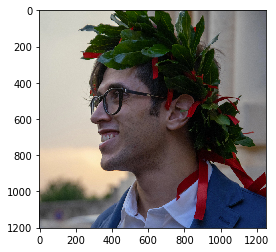

In [77]:
plt.imshow(im_test)

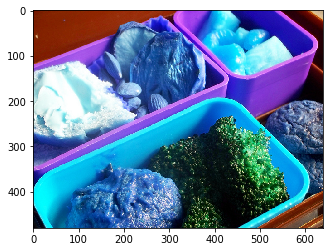

In [68]:
im_test = cv2.imread("/datasets/coco-2014-train/COCO_train2014_000000000009.jpg")
plt.imshow(im_test)

In [69]:
im_test.shape

(480, 640, 3)